# Show counts and percentages for bar plots

In [1]:
import pandas as pd
from plotnine import (
    ggplot,
    aes,
    after_stat,
    stage,
    geom_bar,
    geom_text,
    geom_label,
    position_dodge2,
    facet_wrap,
)
from plotnine.data import mtcars

We can plot a bar graph and easily show the counts for each bar

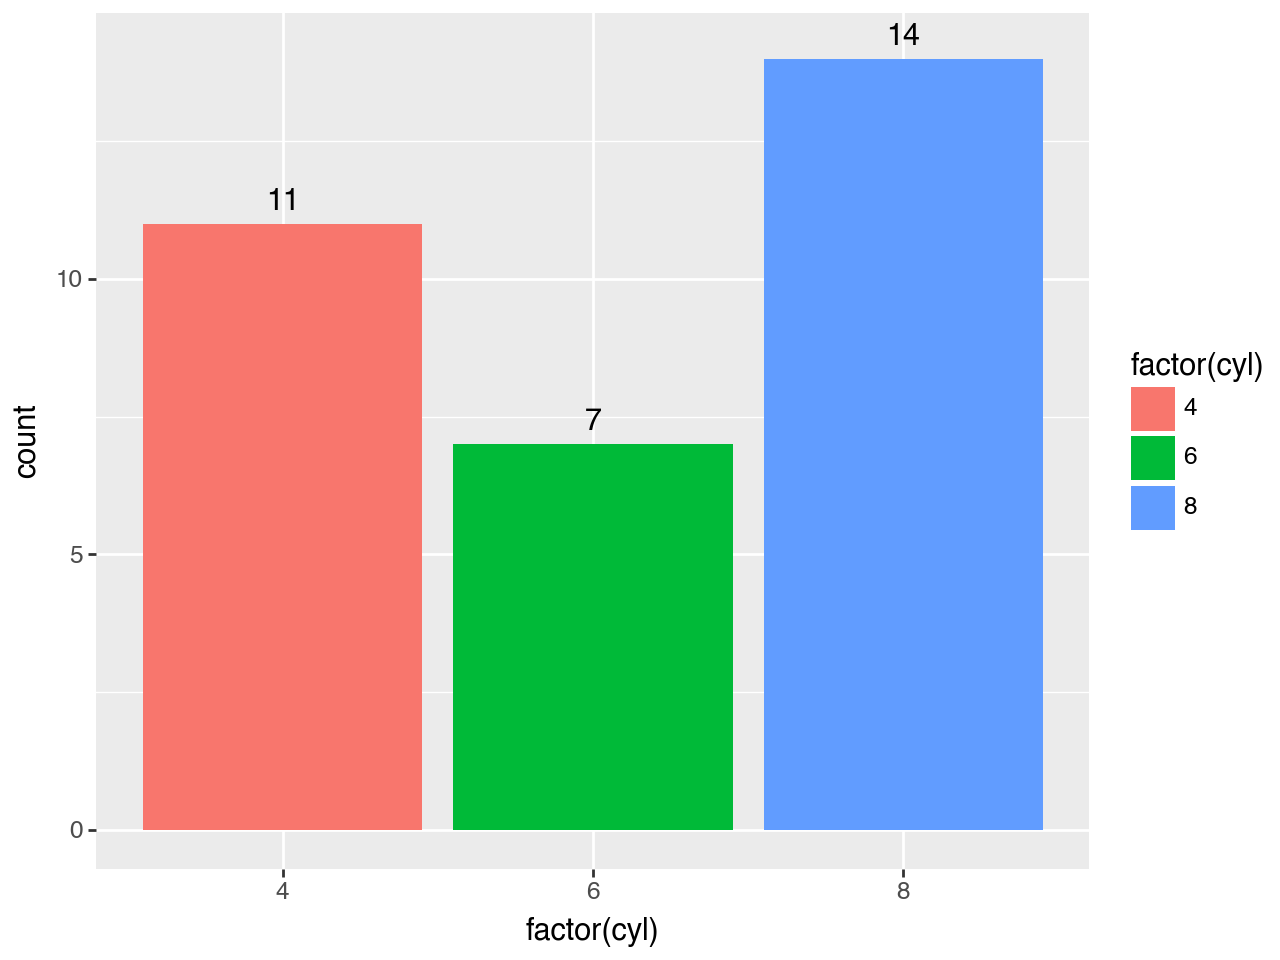

In [2]:
(
    ggplot(mtcars, aes("factor(cyl)", fill="factor(cyl)"))
    + geom_bar()
    + geom_text(
        aes(label=after_stat("count")), stat="count", nudge_y=0.125, va="bottom"
    )
)

`stat_count` also calculates proportions (as `prop`) and a proportion can be converted to a percentage.

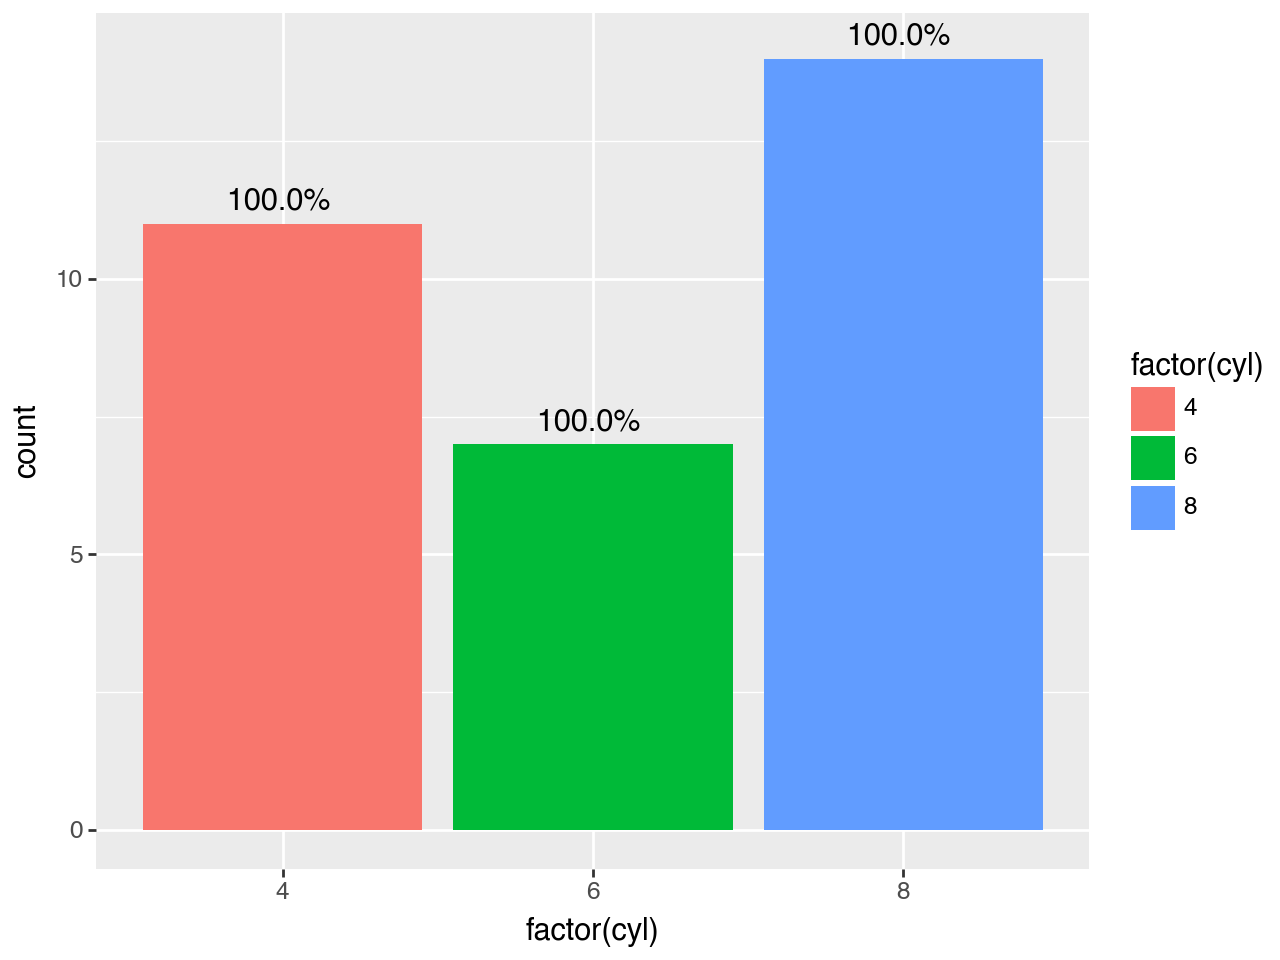

In [3]:
(
    ggplot(mtcars, aes("factor(cyl)", fill="factor(cyl)"))
    + geom_bar()
    + geom_text(
        aes(label=after_stat("prop*100")),
        stat="count",
        nudge_y=0.125,
        va="bottom",
        format_string="{:.1f}% ",
    )
)

These are clearly wrong percentages. The system puts each bar in a separate group.
We need to tell it to put all bars in the panel in single group, so that the percentage
are what we expect.

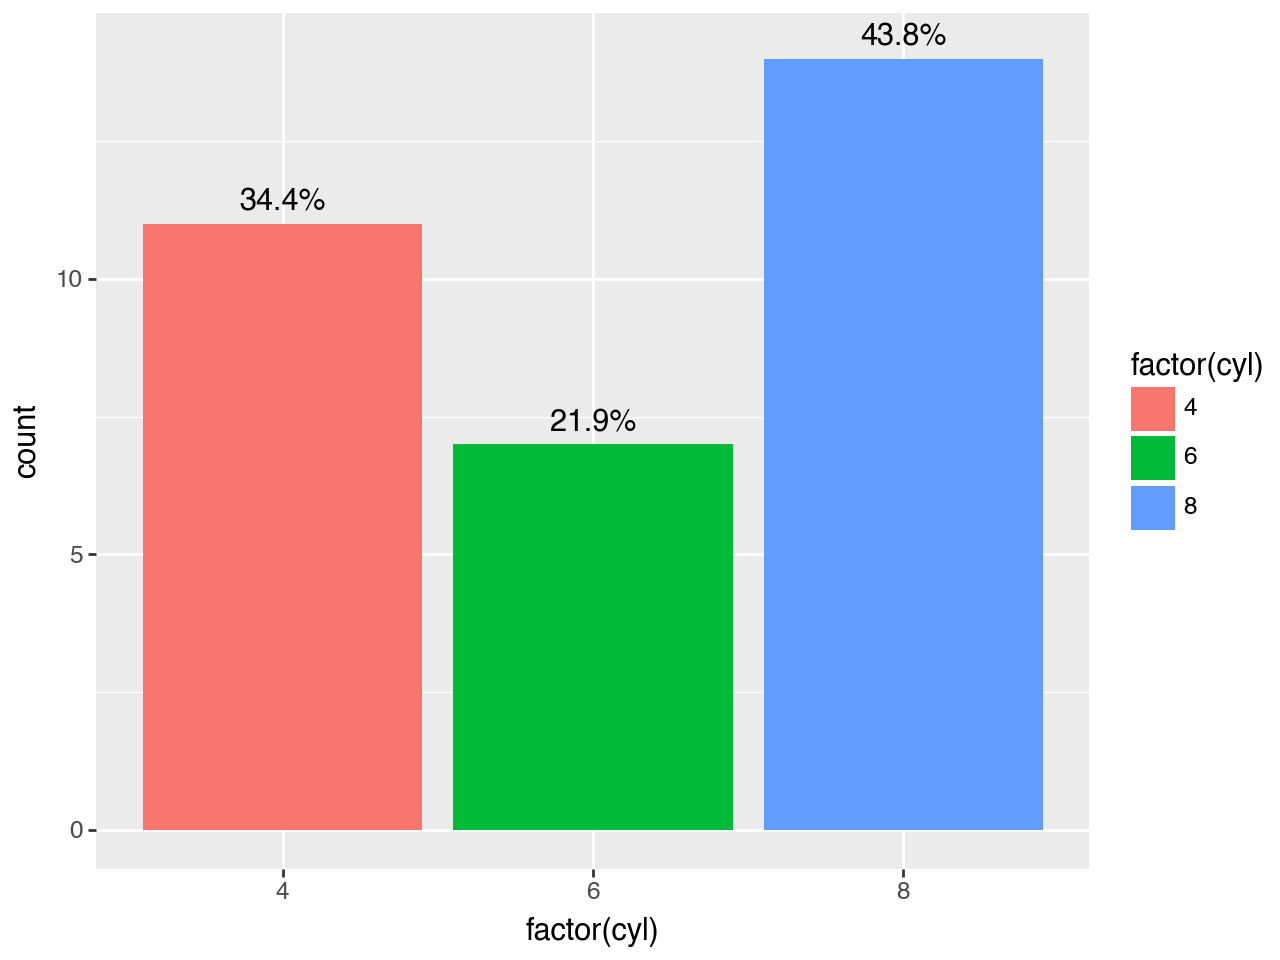

In [4]:
(
    ggplot(mtcars, aes("factor(cyl)", fill="factor(cyl)"))
    + geom_bar()
    + geom_text(
        aes(label=after_stat("prop*100"), group=1),
        stat="count",
        nudge_y=0.125,
        va="bottom",
        format_string="{:.1f}%",
    )
)

Without `group=1`, you can calculate the proportion / percentage after statistics have been calculated. This works because mapping expressions are evaluated across the whole panel. It can work when you have more than 1 categorical.

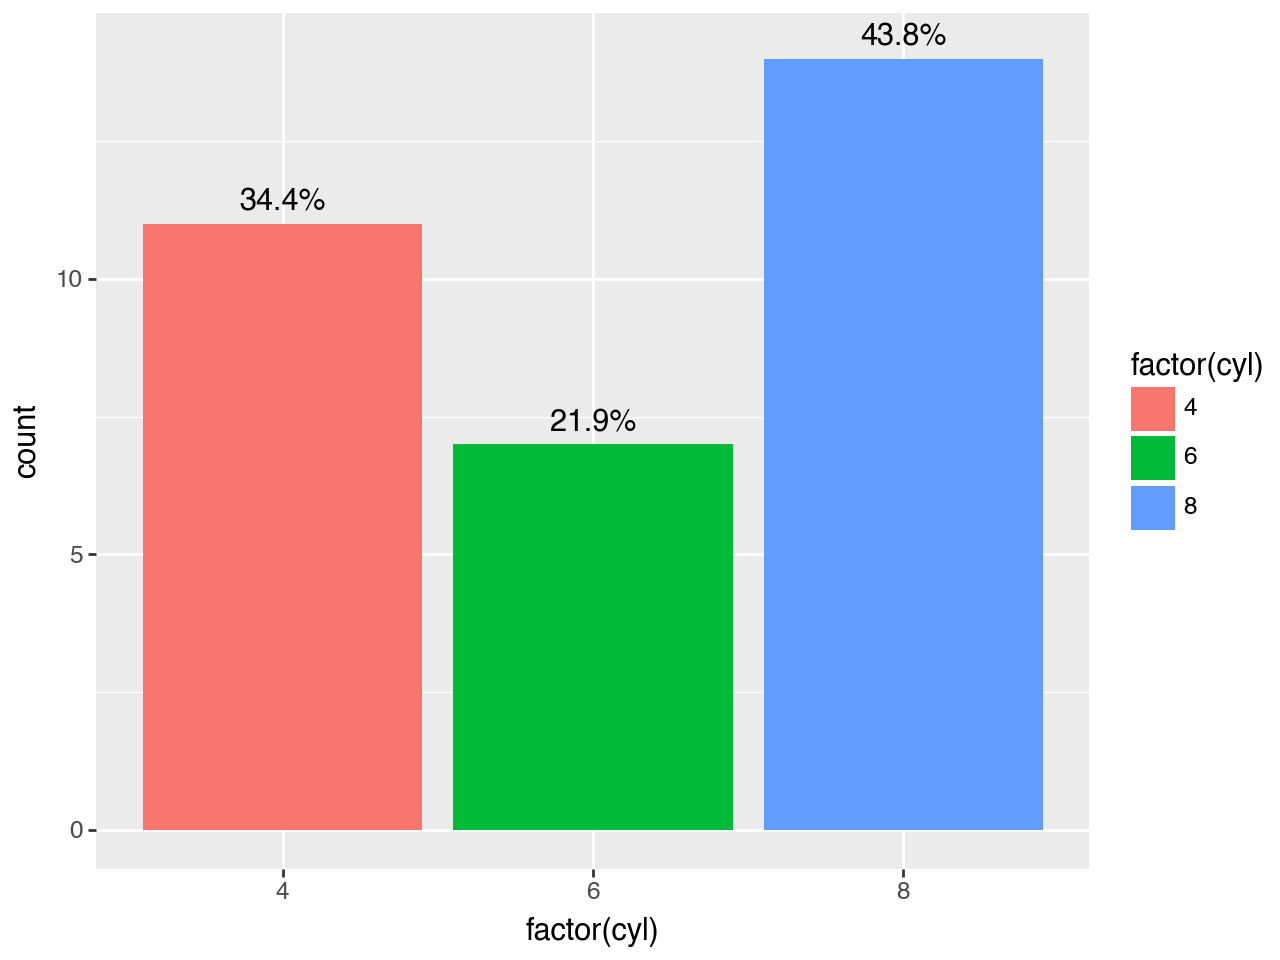

In [5]:
(
    ggplot(mtcars, aes("factor(cyl)", fill="factor(cyl)"))
    + geom_bar()
    + geom_text(
        aes(label=after_stat("count / sum(count) * 100")),
        stat="count",
        nudge_y=0.125,
        va="bottom",
        format_string="{:.1f}%",
    )
)

For more on why automatic grouping may work the way you want, see this [tutorial](./miscellaneous-automatic-grouping-insufficient.ipynb).

We can get the `counts` and we can get the `percentages` we need to print both. We can do that in two ways,

1. Using two `geom_text` layers.

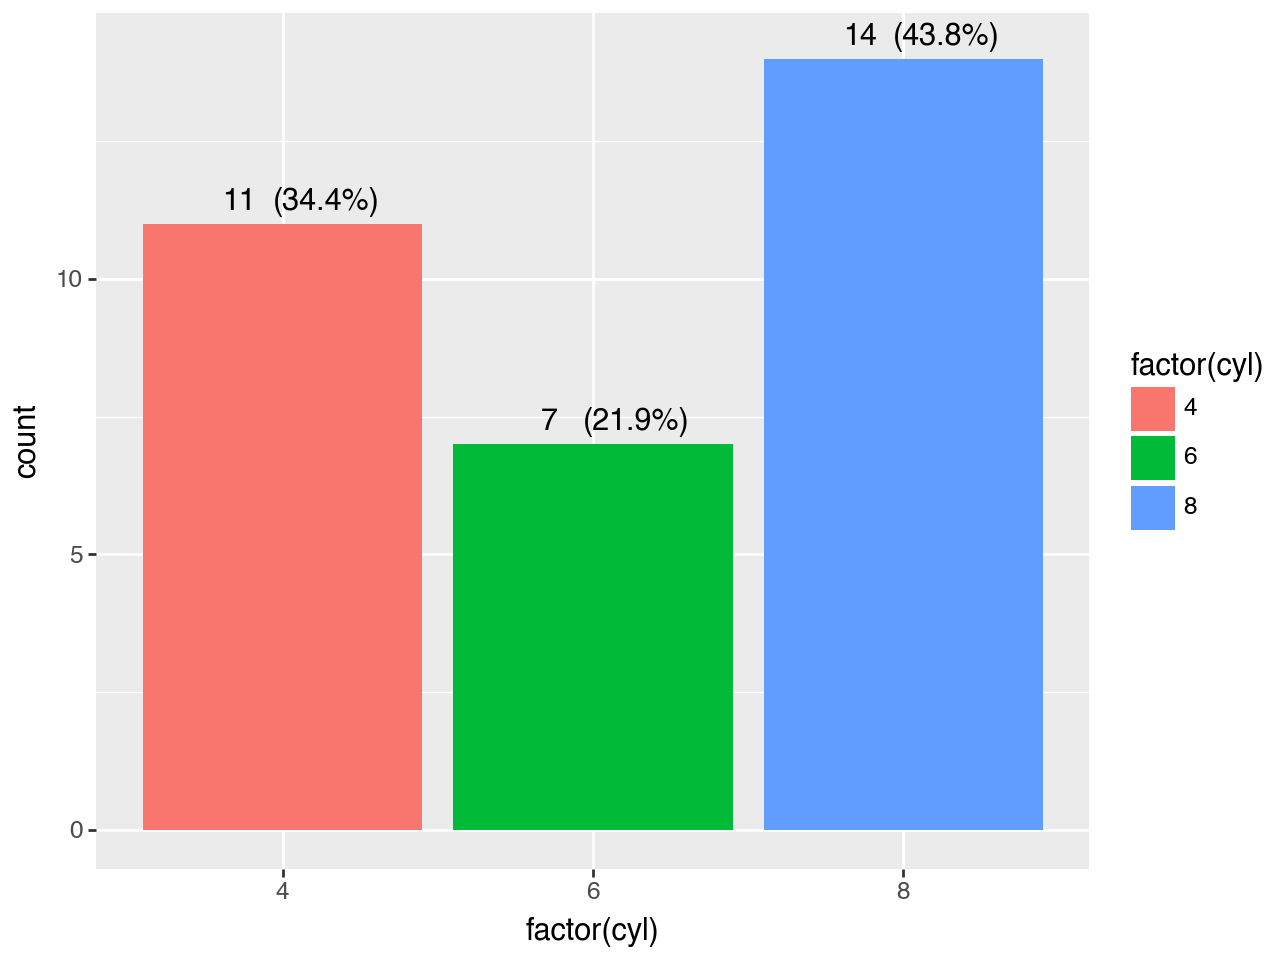

In [6]:
(
    ggplot(mtcars, aes("factor(cyl)", fill="factor(cyl)"))
    + geom_bar()
    + geom_text(
        aes(label=after_stat("count")),
        stat="count",
        nudge_x=-0.14,
        nudge_y=0.125,
        va="bottom",
    )
    + geom_text(
        aes(label=after_stat("prop*100"), group=1),
        stat="count",
        nudge_x=0.14,
        nudge_y=0.125,
        va="bottom",
        format_string="({:.1f}%)",
    )
)

2. Using a function to combine the counts and percentages

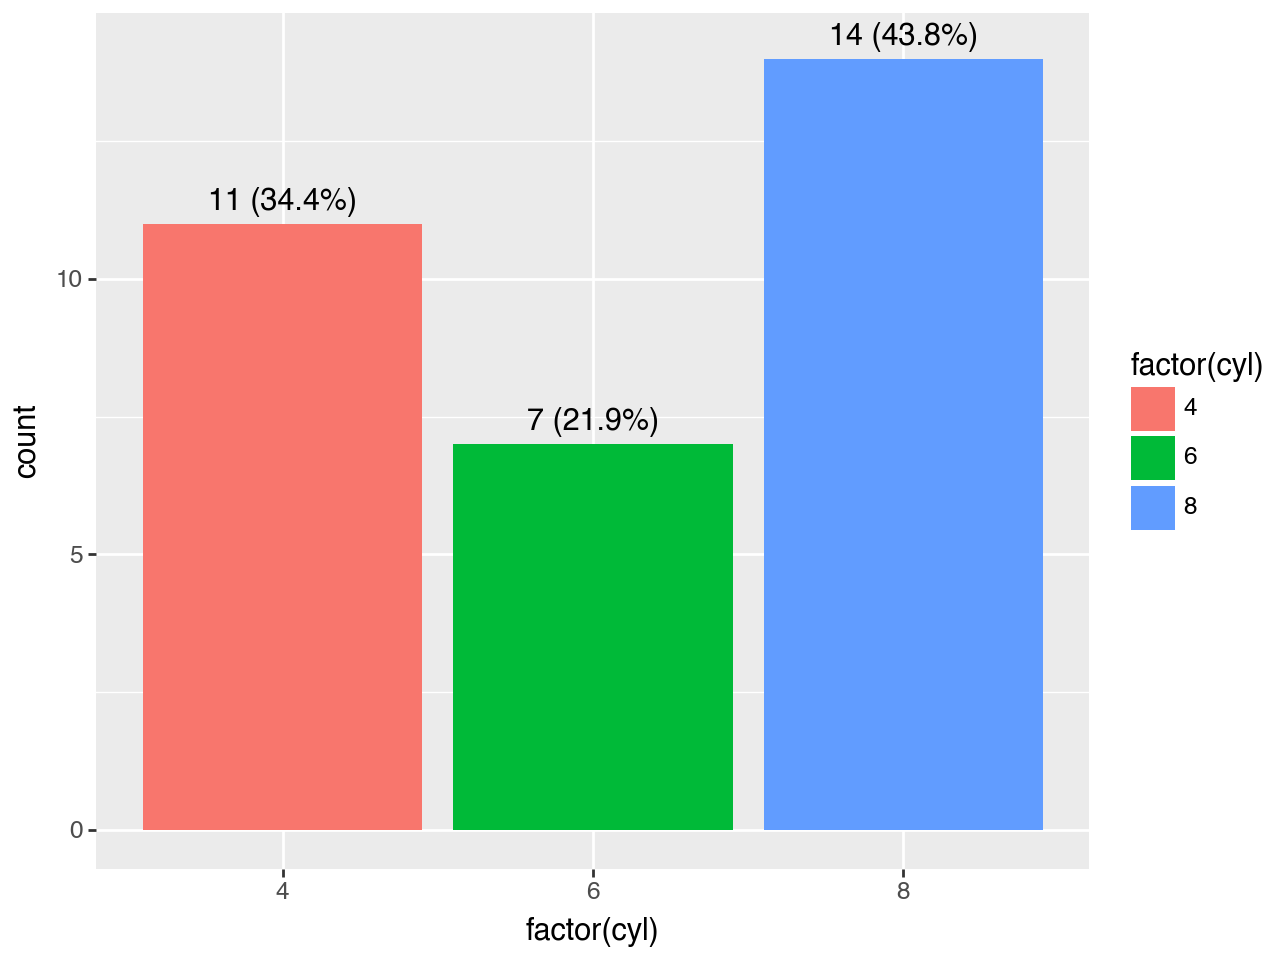

In [7]:
def combine(counts, percentages):
    fmt = "{} ({:.1f}%)".format
    return [fmt(c, p) for c, p in zip(counts, percentages)]


(
    ggplot(mtcars, aes("factor(cyl)", fill="factor(cyl)"))
    + geom_bar()
    + geom_text(
        aes(label=after_stat("combine(count, prop*100)"), group=1),
        stat="count",
        nudge_y=0.125,
        va="bottom",
    )
)

It works with facetting.

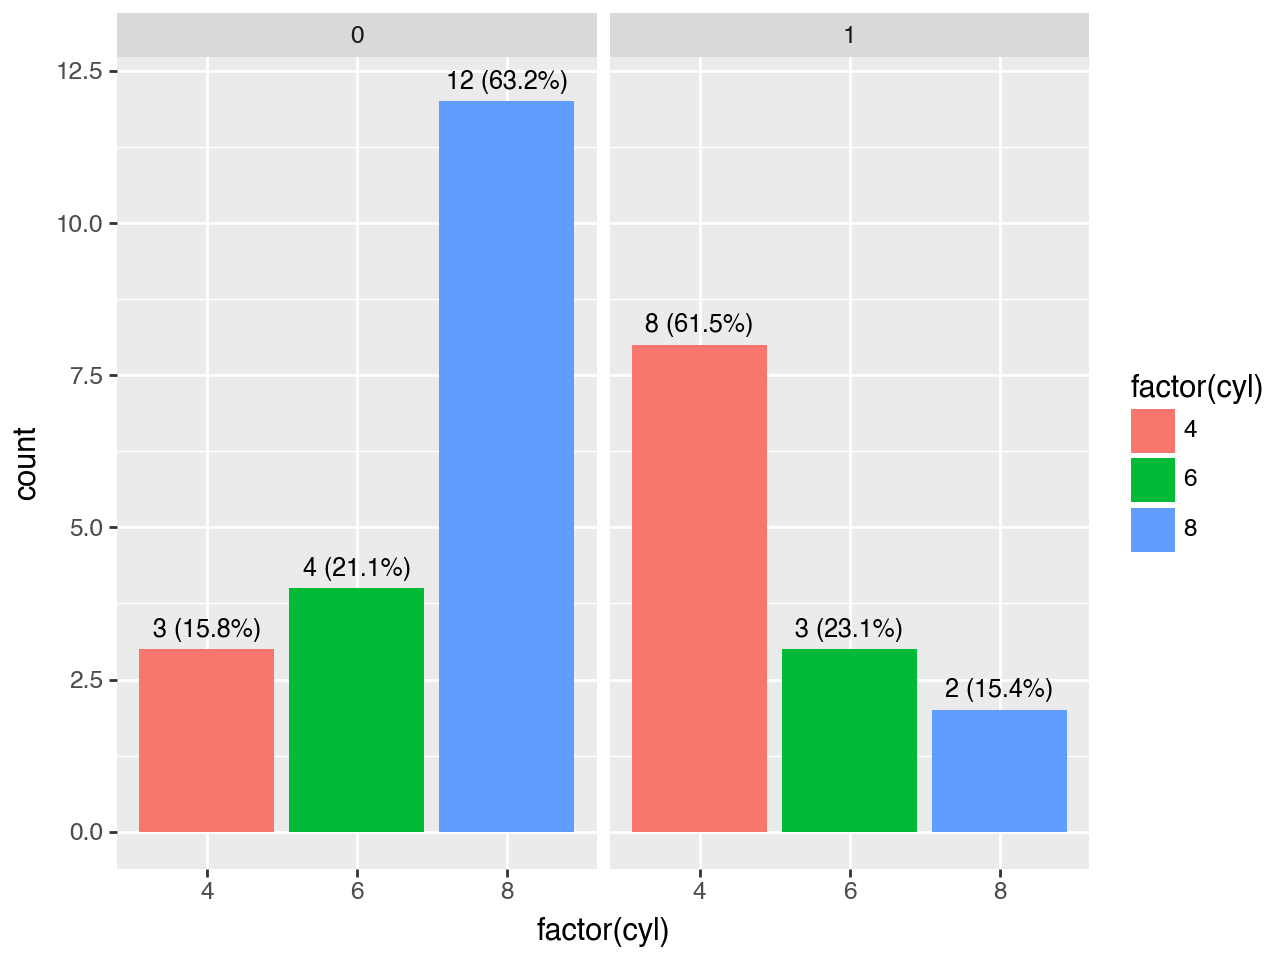

In [8]:
(
    ggplot(mtcars, aes("factor(cyl)", fill="factor(cyl)"))
    + geom_bar()
    + geom_text(
        aes(label=after_stat("combine(count, prop*100)"), group=1),
        stat="count",
        nudge_y=0.125,
        va="bottom",
        size=9,
    )
    + facet_wrap("am")
)

**Credit:** This example was motivated by the github user [Fandekasp](https://github.com/Fandekasp) (Adrien Lemaire) and difficulty he faced in displaying percentages of bar plots.

### Percentages when you have more than one categorical.

`group = 1` does not work when you have more than one categories per `x` location. 

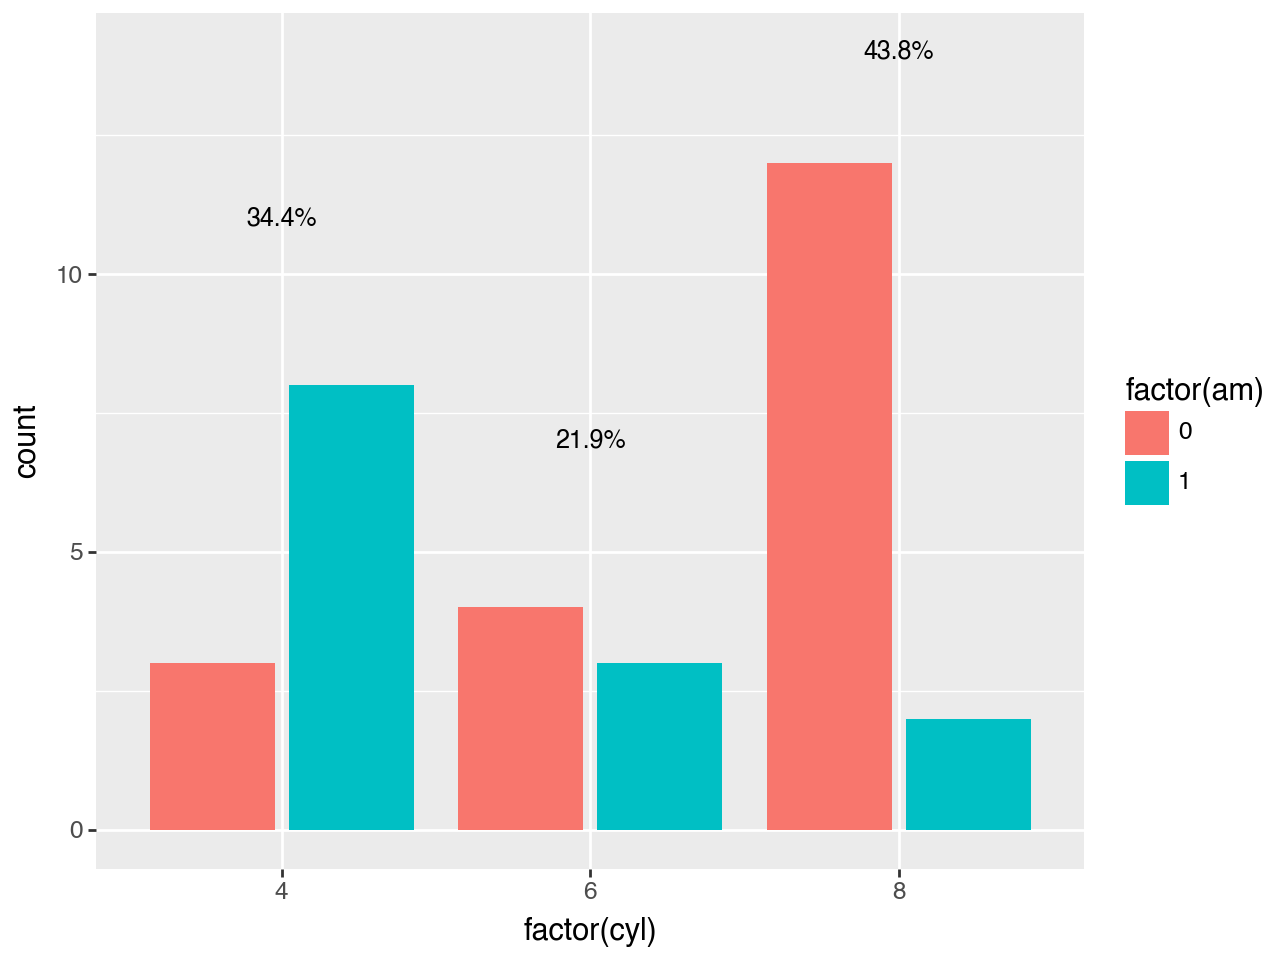

In [9]:
(
    ggplot(mtcars, aes("factor(cyl)", fill="factor(am)"))
    + geom_bar(position="dodge2")
    + geom_text(
        aes(label=after_stat("prop * 100"), group=1),
        stat="count",
        position=position_dodge2(width=0.9),
        format_string="{:.1f}%",
        size=9,
    )
)

You have to calculate the percentages after statistics for the panel have been calculated.

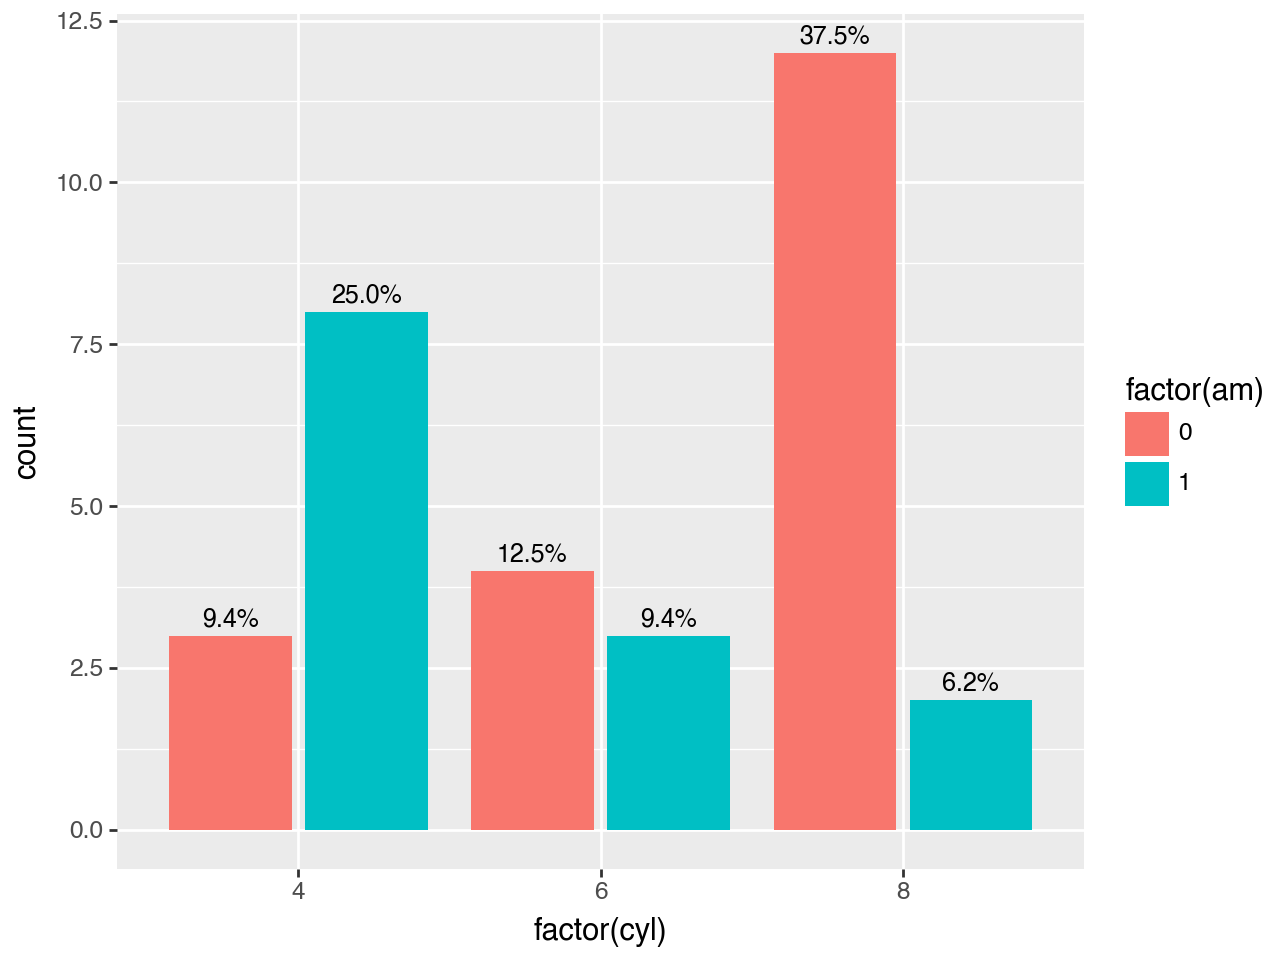

In [10]:
(
    ggplot(mtcars, aes("factor(cyl)", fill="factor(am)"))
    + geom_bar(position="dodge2")
    + geom_text(
        aes(
            label=after_stat("count / sum(count) * 100"),
            y=stage(after_stat="count", after_scale="y + 0.25"),
        ),
        stat="count",
        position=position_dodge2(width=0.9),
        format_string="{:.1f}%",
        size=9,
    )
)

For percentages per bar at each `x` location, you have to group the counts per location can compute the proportions.

### Bars with Group Percentages

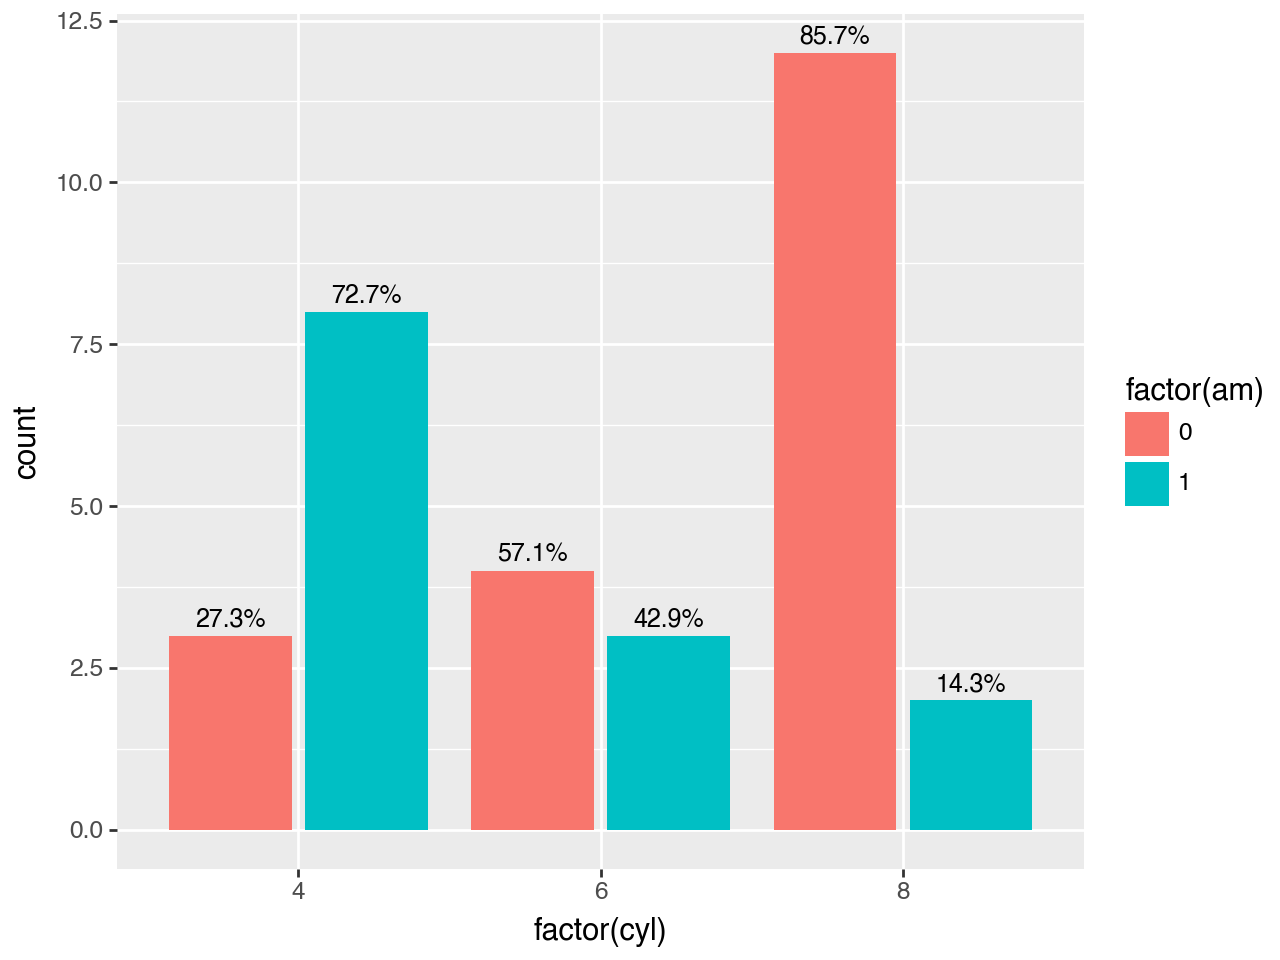

In [11]:
# Gallery, bars

def prop_per_x(x, count):
    """
    Compute the proportion of the counts for each value of x
    """
    df = pd.DataFrame({"x": x, "count": count})
    prop = df["count"] / df.groupby("x")["count"].transform("sum")
    return prop


(
    ggplot(mtcars, aes("factor(cyl)", fill="factor(am)"))
    + geom_bar(position="dodge2")
    + geom_text(
        aes(
            label=after_stat("prop_per_x(x, count) * 100"),
            y=stage(after_stat="count", after_scale="y+.25"),
        ),
        stat="count",
        position=position_dodge2(width=0.9),
        format_string="{:.1f}%",
        size=9,
    )
)

### Stacked Bars with Group Percentages

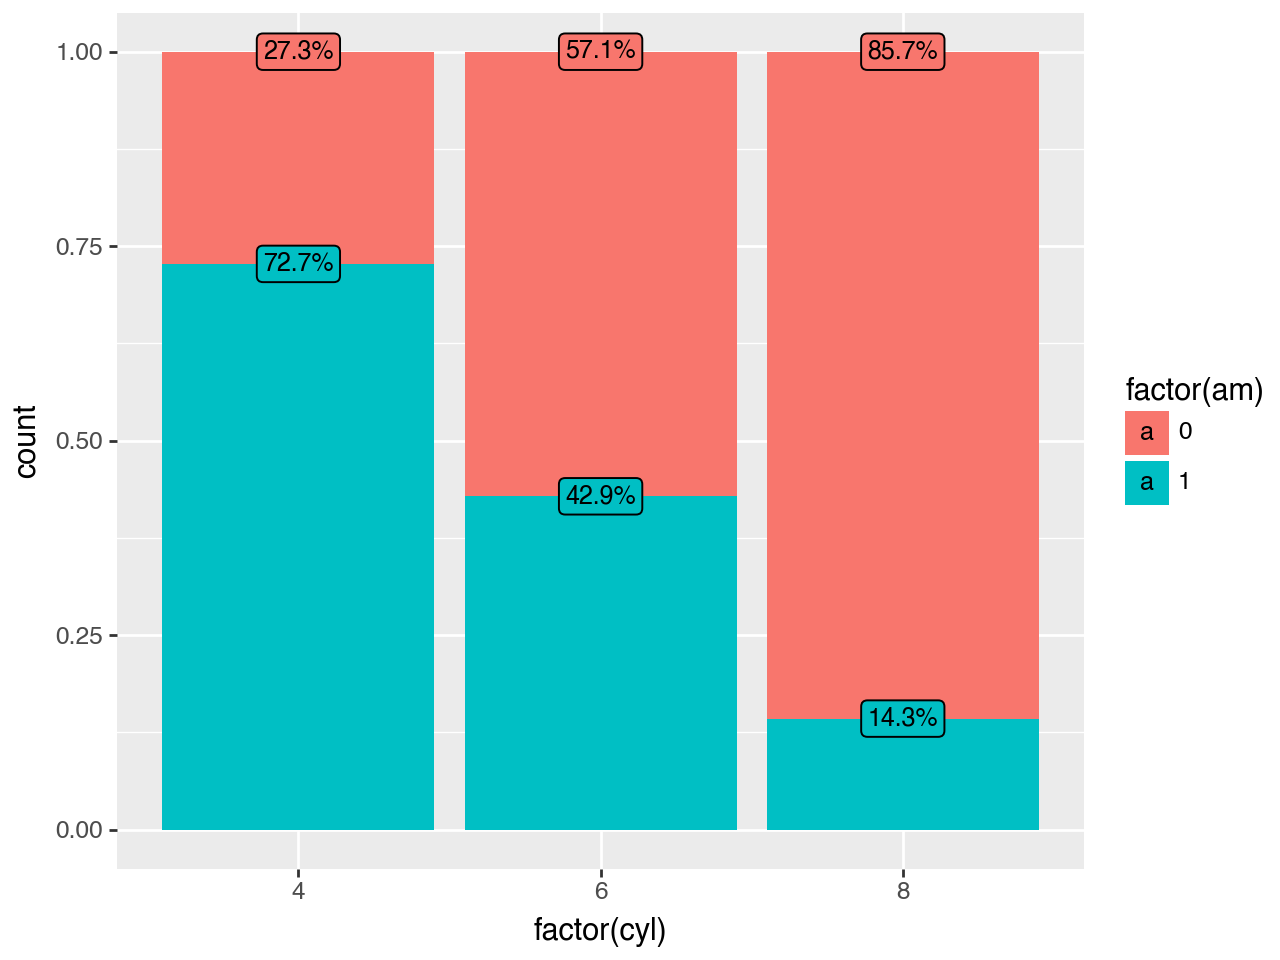

In [12]:
# Gallery, bars
(
    ggplot(mtcars, aes("factor(cyl)", fill="factor(am)"))
    + geom_bar(position="fill")
    + geom_label(
        aes(label=after_stat("prop_per_x(x, count) * 100")),
        stat="count",
        position="fill",
        format_string="{:.1f}%",
        size=9,
    )
)

**NOTE**

With more categories, if it becomes harder get the right groupings withing plotnine, the solution is to do all (or most) the data manipulation in pandas then plot using `geom_col + geom_text`.